---

## Введение

**Цель проекта:** Необходимо проверить гипотезы для увеличения выручки.

**Задачи проекта:**

- Приоритизировать гипотезы, 
- Запустить A/B-тест 
- Проанализировать результаты.

**Для выполнения работы будут использованы следующие библиотеки:**

pandas
numpy
seaborn
matplotlib.pyplot
pymystem3
stats

In [2]:
import pandas as pd
pd.set_option('max_colwidth', 400)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math
import scipy.stats as stats


from pymystem3 import Mystem
from IPython.display import display

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

## Открытие и подготовка данных

In [8]:
try:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv', sep=',') 
except Exception:
        hypothesis = pd.read_csv('/datasets/hypothesis.csv')
display(hypothesis.sample(5))  

,Hypothesis,Reach,Impact,Confidence,Efforts
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6


In [9]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [10]:
try:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', sep=',') 
except Exception:
        orders = pd.read_csv('/datasets/orders.csv')
display(orders.sample(5))  

,transactionId,visitorId,date,revenue,group
398,2084190534,3673190339,2019-08-28,3890,A
558,3621273697,3941503500,2019-08-06,4990,B
1019,453824282,4256040402,2019-08-31,1850,B
628,1483298733,2201480904,2019-08-29,400,B
482,1715714627,495712671,2019-08-06,1790,A


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
try:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', sep=',') 
except Exception:
        visitors = pd.read_csv('/datasets/visitors.csv')
display(visitors.sample(5))  

,date,group,visitors
11,2019-08-12,A,595
6,2019-08-07,A,644
55,2019-08-25,B,679
17,2019-08-18,A,668
0,2019-08-01,A,719


In [ ]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Вывод:** Нам передали три файла: hypothesis содержащий гипотезы и критерии её значимости и трудоемкости. А так же данные с результатами A/B теста - количеством визитов и заказов на площадке. 

Необходимые изменения в данных: 

hypothesis

- Изменение типа данных с int64 до int32 для всех столбцов, кроме Hypothesis
- Написание названия столбцов со строчной буквы

orders и visitors

- Перевод дат в формат даты
- Перевод столбцов revenue и visitors в int32

### Первичная обработка данных

Приведем в порядок данные файла hypothesis.

In [ ]:
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts'] #Приведем столбцы к нижнему регистру

In [ ]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [ ]:
hypothesis['reach'] = hypothesis['reach'].astype('int16')
hypothesis['impact'] = hypothesis['impact'].astype('int16')
hypothesis['confidence'] = hypothesis['confidence'].astype('int16')
hypothesis['efforts'] = hypothesis['efforts'].astype('int16')

Наведем порядок в данных orders и visitors

In [ ]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

# Поменяем формат на даты

In [ ]:
orders['revenue'] = orders['revenue'].astype('int32')
visitors['visitors'] = visitors['visitors'].astype('int32')

Проверим базы данных на дубликаты.

In [ ]:
orders[orders.duplicated()] 

,transactionId,visitorId,date,revenue,group


In [ ]:
visitors[visitors.duplicated()] 

,date,group,visitors


**Вывод** Все данные полные, т.е. не содержат пропусков. Названия столбцов упорядочены. Типы данных приведены к верным. Там, где это оправдано сокращена разрядность типов данных. Базы посетителей и покупок не содержат дублирующих записей. 

## Приоритизация гипотез

Проведем приоритезацию гипотез методом ICE и RICE:

In [ ]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis', 'ICE']].round().sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0


In [ ]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']) / hypothesis['efforts']

display(hypothesis[['hypothesis', 'RICE']].round().sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По критерию ICE ТОП 5 гипотез это: № 8,0,7,6 и 2. Приоритезация гипотиз в RICE изменилась из-за охвата. В RICE на первом месте гипотеза № 7. Затем - 2,0,6 и 8.

In [ ]:
hypothesis_1 = hypothesis.reset_index()
display(hypothesis_1.round())

,index,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0,40.0
1,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
2,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
3,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0,9.0
4,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0
5,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0,4.0
6,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
7,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0,112.0
8,8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0,16.0


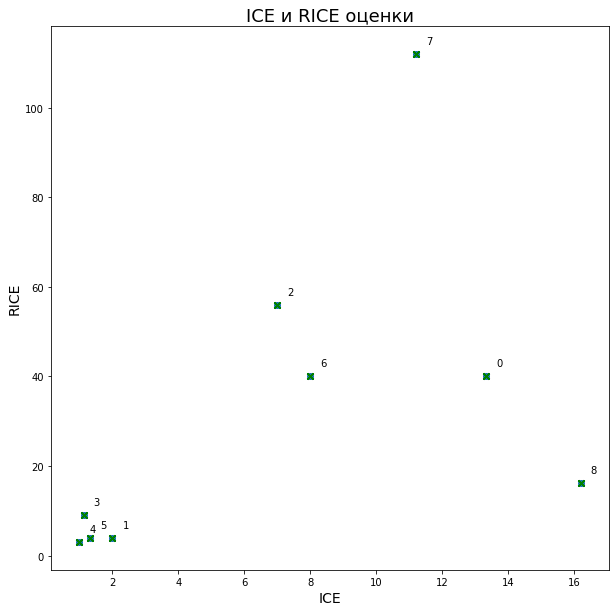

In [ ]:
x = hypothesis_1['ICE'].values
y = hypothesis_1['RICE'].values
types = hypothesis_1.reset_index()['index'].values

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)

ax.set_xlabel('ICE', fontsize=14)
ax.set_ylabel('RICE', fontsize=14)
ax.set_title('ICE и RICE оценки', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='green')

## Анализ A/B-теста

### График кумулятивной выручки по группам

Для разбора данных изучим датасет orders. 

In [68]:
df = orders.groupby(["group"]).agg({"revenue": ["count", "sum"]}).reset_index()
df.columns = ["group", "revenue_count", "revenue_sum"]
df["average"] = (df["revenue_sum"] / df["revenue_count"]).round(1)
display(df)

,group,revenue_count,revenue_sum,average
0,A,557,4084803,7333.6
1,B,640,5907760,9230.9


Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulativeData со столбцами:
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates():

In [69]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 
display(datesGroups.sample(3))

,date,group
1149,2019-08-14,B
698,2019-08-05,A
540,2019-08-20,A


In [70]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(orders["date"] <= x["date"], orders["group"] == x["group"])
    ].agg(
        {
            "date": "max",
            "group": "max",
            "transactionId": pd.Series.nunique,
            "visitorId": pd.Series.nunique,
            "revenue": "sum",
        }
    ),
    axis=1,
).sort_values(by=["date", "group"])

In [71]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(visitors["date"] <= x["date"], visitors["group"] == x["group"])
    ].agg({"date": "max", "group": "max", "visitors": "sum"}),
    axis=1,
).sort_values(by=["date", "group"])

In [72]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=["date", "group"], right_on=["date", "group"]
)
cumulativeData.columns = ["date", "group", "orders", "buyers", "revenue", "visitors"]

display(cumulativeData.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


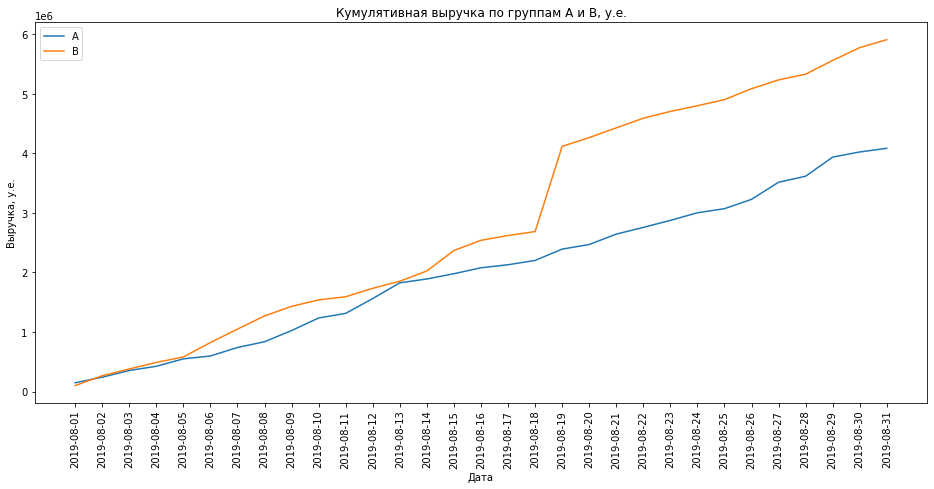

In [73]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(16,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=90)
plt.title('Кумулятивная выручка по группам А и В, у.е.')
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')

plt.legend()
plt.show()

---

**Вывод:** Группа В показывает значительно лучшие показатели по коммулятивной величине среднего чека, чем группа А. На графике есть резкий всплеск выручки, что может говорить о выбросах или резком росте числа крупных заказов. 

### График кумулятивного среднего чека по группам

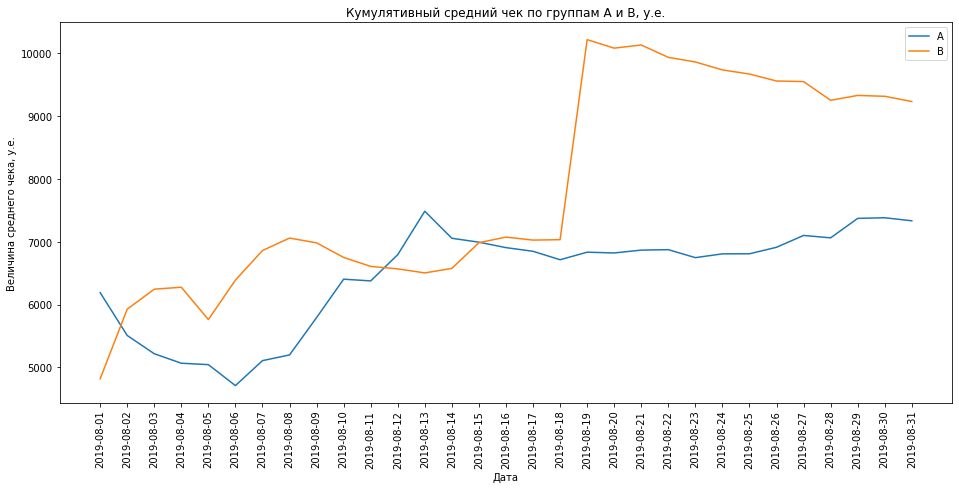

In [74]:
plt.figure(figsize=(16,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.xticks(rotation=90)
plt.title('Кумулятивный средний чек по группам А и В, у.е.')
plt.xlabel('Дата')
plt.ylabel('Величина среднего чека, у.е.')


plt.legend()
plt.show()

**Вывод:** В период с 17 по 21 августа наблюдается резкий скачок величины кумулятивного среднего чека в группе В. Группа А в среднем показывает более слыбый результат в тестировании. 

### График относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline() 

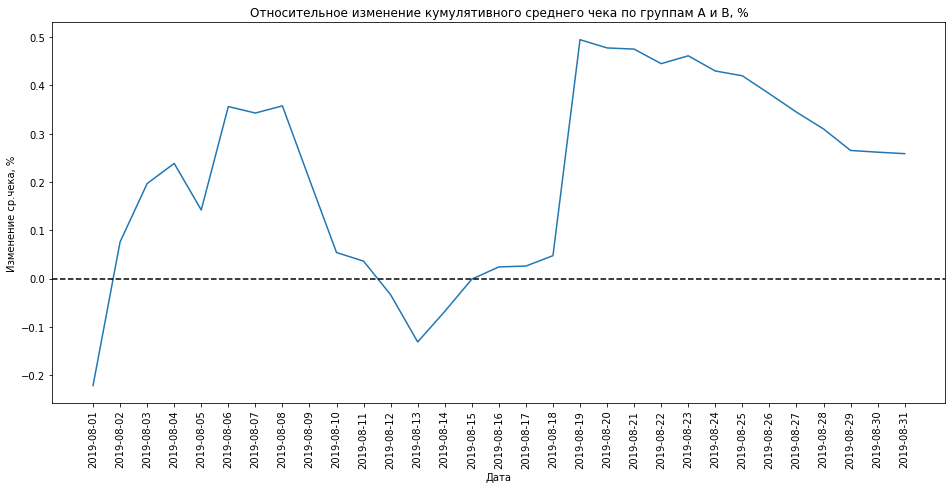

In [75]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(16,7))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']
    /mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')


plt.xticks(rotation=90)
plt.title('Относительное изменение кумулятивного среднего чека по группам А и В, %')
plt.xlabel('Дата')
plt.ylabel('Изменение ср.чека, %')


plt.show()

**Вывод:** Наблюдаются резкие скачки графика 01 августа, 05 августа, 13 августа и 20 августа. Далее мы более подробно проанализируем, с чем связано резкое исменение динамики среднего чека. 

### График кумулятивной конверсии по группам

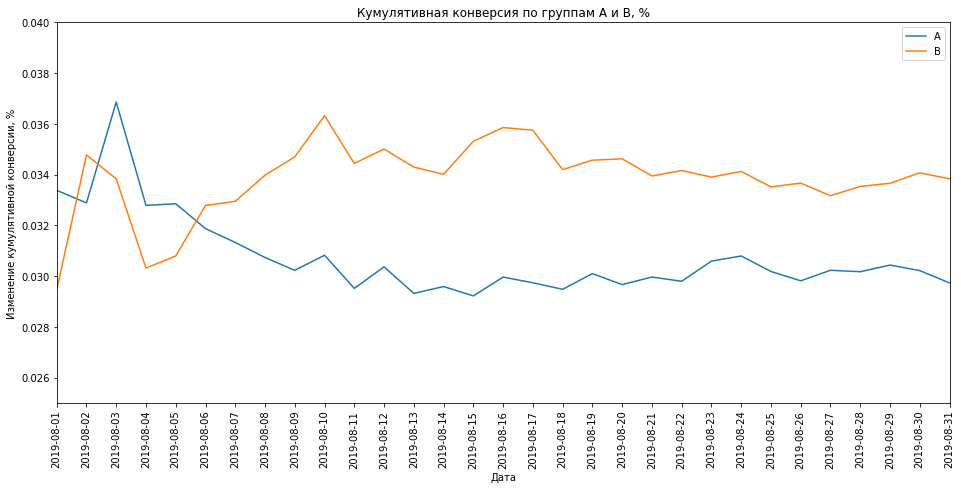

In [76]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(16,7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.04])


plt.xticks(rotation=90)
plt.title('Кумулятивная конверсия по группам А и В, %')
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивной конверсии, %')


plt.show()

**Вывод:** Кумулятивная конверсия группы В вырвалась вперёд еще 06 августа, а конверсия группы А в этот же период просела.

### График относительного изменения кумулятивной конверсии группы B к группе A

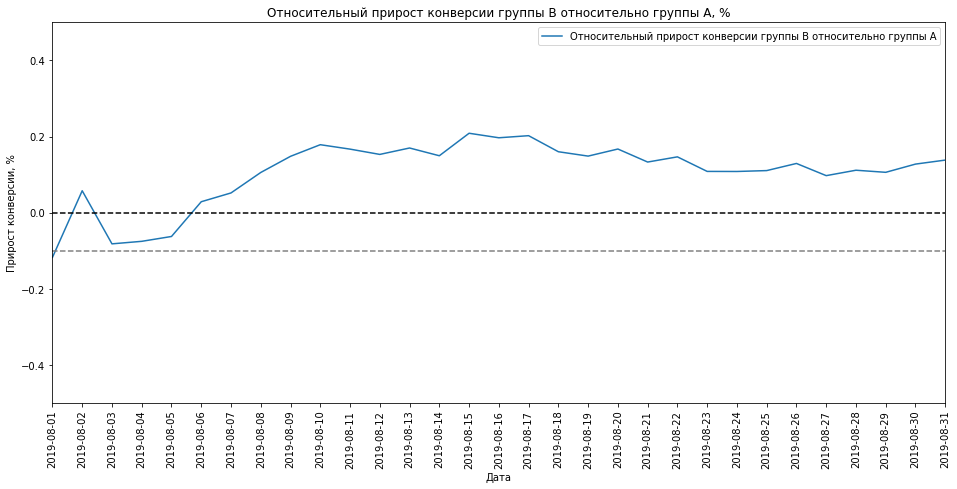

In [77]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],
    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(16,7))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']
    /mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5])


plt.xticks(rotation=90)
plt.title('Относительный прирост конверсии группы B относительно группы A, %')
plt.xlabel('Дата')
plt.ylabel('Прирост конверсии, %')


plt.show()

**Вывод:** В начале теста группа B проигрывала группе A, затем вырвалась вперёд и заняла лидирующие положении. В целом отношение конверсии скорее уже установилось и группа В лидирует.

### Точечный график количества заказов по пользователям

In [78]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']

display(ordersByUsers.sort_values(by='orders', ascending=False).head(5)) 

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


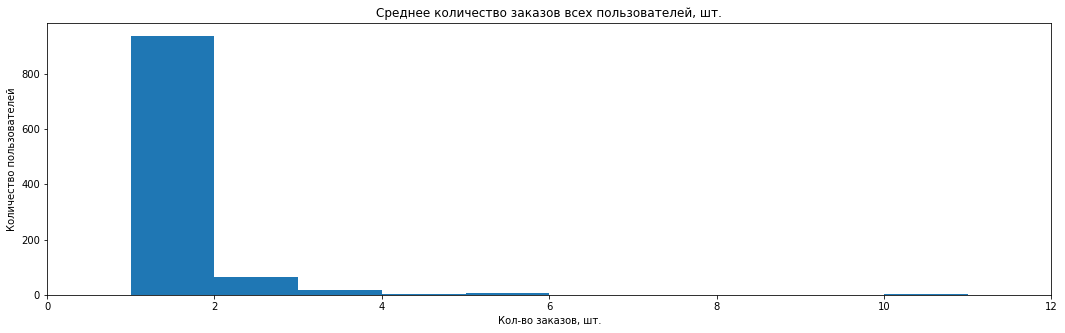

In [79]:
plt.figure(figsize=(18,5))
plt.hist(ordersByUsers['orders']) 
plt.xlim(0,12)
plt.xlabel('Кол-во заказов, шт.')
plt.title('Среднее количество заказов всех пользователей, шт.')
plt.ylabel('Количество пользователей')
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-3 заказами тоже значительна.

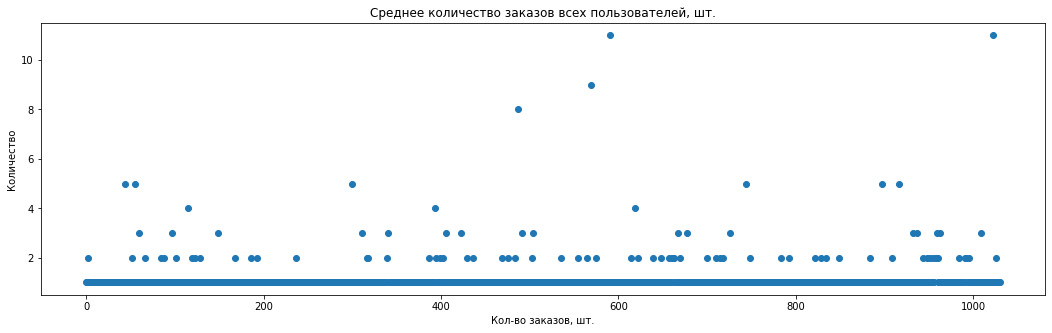

In [80]:
plt.figure(figsize=(18,5))
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
#plt.xlim(0,12) #убрала не корректную обрезку


plt.xlabel('Кол-во заказов, шт.')
plt.title('Среднее количество заказов всех пользователей, шт.')
plt.ylabel('Количество')
plt.show()

---

**Вывод:** Выводы подтверждаются: много пользователей с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

### 95-й и 99-й перцентили количества заказов на пользователя

In [81]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


**Вывод:** Не более 5% пользователей оформляли больше чем 2 заказа. И 1% пользователей заказывали более 4 раз.
Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

### Точечный график стоимостей заказов

Изучим выручку по пользователям

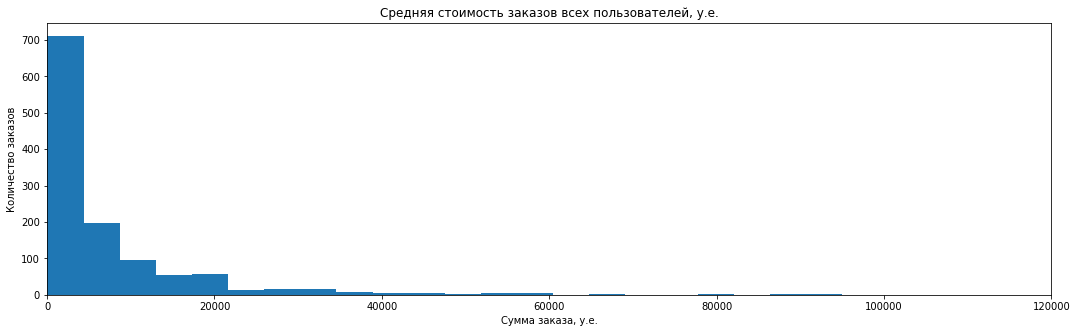

In [82]:
plt.figure(figsize=(18,5))
plt.hist(orders['revenue'],bins=300)
plt.xlim(0,120000)
plt.xlabel('Сумма заказа, у.е.')
plt.title('Средняя стоимость заказов всех пользователей, у.е.')
plt.ylabel('Количество заказов')
plt.show()

Большинство заказов для всех групп находится в диапазоне до 21 тыс у.е.

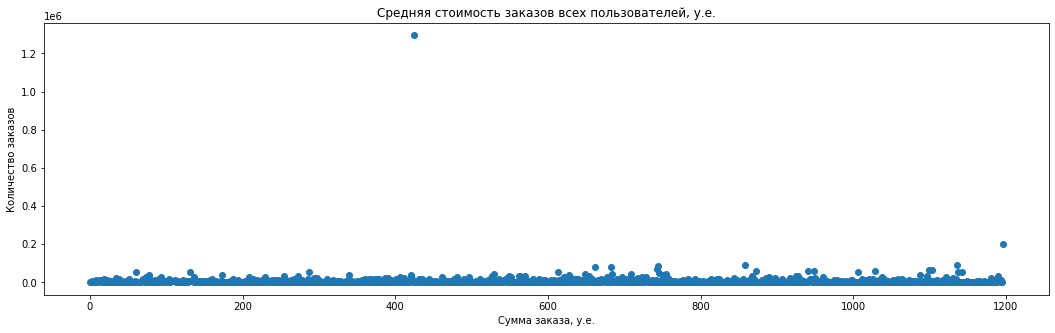

In [83]:
plt.figure(figsize=(18,5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Сумма заказа, у.е.')
plt.title('Средняя стоимость заказов всех пользователей, у.е.')
plt.ylabel('Количество заказов')
plt.show()

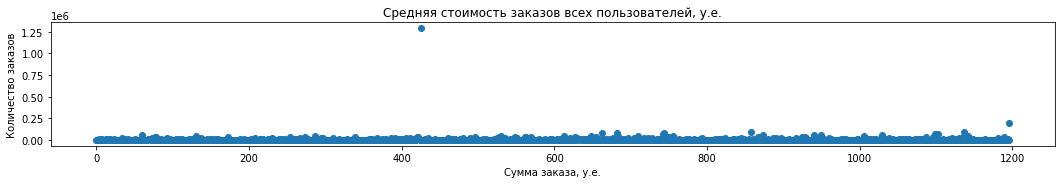

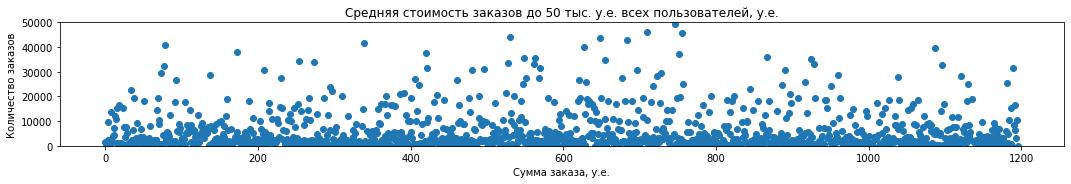

In [84]:
#plot 1:
plt.figure(figsize=(18,5))
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.subplot(2, 1, 1)
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Сумма заказа, у.е.')
plt.title('Средняя стоимость заказов всех пользователей, у.е.')
plt.ylabel('Количество заказов')


#plot 2:
plt.figure(figsize=(18,5))
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.subplot(2, 1, 2)
plt.scatter(x_values, orders['revenue']) 
plt.ylim(0,50000)
plt.xlabel('Сумма заказа, у.е.')
plt.title('Средняя стоимость заказов до 50 тыс. у.е. всех пользователей, у.е.')
plt.ylabel('Количество заказов')

plt.show()

In [85]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

**Вывод:** У нас есть один заказ на сумму 1,294 млн в группе В, который существенно изменяет картину данных.

### 95-й и 99-й перцентили стоимости заказов

In [96]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


**Вывод:** В представленных данных не более 5% заказов дороже 28 000 у.е. и не более 1% дороже 58 233.2 у.е. Т.о. мы сможем исключить из выборки все заказы дороже 28 000 у.е.

### Статистическая значимость различий конверсии между группами по «сырым» данным

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей

Гипотеза:

- H0 - конверсия по двум группам характеризуется статистически незначимыми различиями
- H1 - конверсия по двум группам характеризуется статистически значимыми различиями

Уровень статистической значимости alpha = 0.05

In [87]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5)) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Посчитаем статистическую значимость различия в конверсии между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [88]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [89]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

---

In [90]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value сырых данных по конверсии:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
print('Относительное отличие группы А к группе B по конверсии:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value сырых данных по конверсии: 0.017
Относительное отличие группы А к группе B по конверсии: 0.138


**Вывод:** По «сырым» данным есть различия в конверсии групп A и B.
Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. 
Однако относительный выйгрыш группы B равен 13,8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов.
А ещё найдём относительные различия в среднем чеке между группами:

Гипотеза:

- H0 - средний чек по двум группам характеризуется статистически незначимыми различиями
- H1 - средний чек по двум группам характеризуется статистически значимыми различиями

Уровень статистической значимости alpha = 0.05

In [91]:
print('P-value сырых данных по среднему чеку:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('Относительное отличие группы А к группе B по среднему чеку:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value сырых данных по среднему чеку: 0.729
Относительное отличие группы А к группе B по среднему чеку: 0.259


**Вывод:** P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

Посчитаем статистическую значимость различия конверсии после удаления "аномальных" пользователей.
Создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах — не включая "аномальных" пользователей.

Гипотеза:

- H0 - конверсия по двум группам характеризуется статистически незначимыми различиями
- H1 - конверсия по двум группам характеризуется статистически значимыми различиями

Уровень статистической значимости alpha = 0.05

In [92]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [93]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('P-value очищенных данных по конверсии:', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print('Относительное отличие группы А к группе B по конверсии:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value очищенных данных по конверсии: 0.013
Относительное отличие группы А к группе B по конверсии: 0.173


**Вывод:** Первое число — p-value = 0.013 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выйгрыш группы B равен 17,3%.

In [94]:
print('Количество аномальных пользователей', abnormalUsers.shape, 'человека') 

Количество аномальных пользователей (74,) человека


###  Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Гипотеза:

- H0 - средний чек по двум группам характеризуется статистически незначимыми различиями
- H1 - средний чек по двум группам характеризуется статистически значимыми различиями

Уровень статистической значимости alpha = 0.05

In [95]:
print('P-value очищенных данных по среднему чеку:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
         alternative = 'two-sided')[1]
    )
)

print('Относительное отличие группы А к группе B по среднему чеку:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value очищенных данных по среднему чеку: 0.738
Относительное отличие группы А к группе B по среднему чеку: -0.020


**Вывод:** P-value чищенных данных по среднему чеку значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B значительно выше среднего чека группы A.

## Вывод

Имеющиеся факты:
- По конверсии между группами есть статистически значимые различия и по «сырым», и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы А хуже группы В и нет значительной тенденции к улучшению.
- График различия среднего чека говорит о том, что результаты группы А ухудшаются день ото дня.

**Итог исследования:**

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. По конверсии группа В значительно превзошла группу А. Изменения, примененные к группе В нужно распространить на всю аудиторию интернет магазина. 

Следующий тест, который нужно провести нужно направить на увеличение среднего чека. 
По приоритезеции гипотез можно внедрить форму подписки на все основные страницы сайта и добавить блоки рекомендаций товаров на сайт.